## Description:

    Use DeSeq2 to identify differential abundance among treatments
    Following  Ashley's succ-C notebook


# Setting variables

In [26]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/'
#using physeq file with sparsity of greater than 3 in 3 samples
physeqFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3'

# Init

In [27]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [28]:
%%R
# The required package list:
reqpkg = c("plyr","BiocParallel","doParallel", "DESeq2", "foreach", "ggplot2", 
   "gridExtra","scales", "metagenomeSeq", "phyloseq", "dplyr", "tidyr", 
           "reshape", "vegan")
# Load all required packages and show version
for (i in reqpkg) {
    print(i)
    print(packageVersion(i))
    suppressMessages(library(i, quietly = TRUE, verbose = FALSE, 
                             warn.conflicts = FALSE, character.only = TRUE))
}

[1] "plyr"
[1] ‘1.8.3’
[1] "BiocParallel"
[1] ‘1.0.3’
[1] "doParallel"
[1] ‘1.0.8’
[1] "DESeq2"
[1] ‘1.6.3’
[1] "foreach"
[1] ‘1.4.2’
[1] "ggplot2"
[1] ‘1.0.1’
[1] "gridExtra"
[1] ‘2.0.0’
[1] "scales"
[1] ‘0.3.0’
[1] "metagenomeSeq"
[1] ‘1.11.10’
[1] "phyloseq"
[1] ‘1.10.0’
[1] "dplyr"
[1] ‘0.4.3’
[1] "tidyr"
[1] ‘0.3.1’
[1] "reshape"
[1] ‘0.8.5’
[1] "vegan"
[1] ‘2.3.0’


In [36]:
%%R
register(MulticoreParam(20))

# Loading phyloseq object

In [29]:
%%R -i physeqFile

physeq.Full = readRDS(physeqFile)
physeq.Full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 238 samples ]
sample_data() Sample Data:       [ 238 samples by 44 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


In [33]:
%%R

#re-order levels 
sample_data(physeq.Full)$Plant = relevel(sample_data(physeq.Full)$Plant, "BARE")

#Set DAP as factor
sample_data(physeq.Full)$DAP = factor(sample_data(physeq.Full)$DAP) 
sample_data(physeq.Full)$DAP %>% levels

[1] "36" "53" "57" "61" "72" "79" "84" "88"


## Create DeSeq2 object

# Function generating plant log2fold change figure

In [49]:
%%R

asNumeric = function(x) { as.numeric(as.character(x)) }

get_Ps = function(physeq.obj) {
    diagdds = phyloseq_to_deseq2(physeq.obj, ~Plant)
    diagdds = DESeq(diagdds, quiet = TRUE, parallel = TRUE)
    theta = 0.5
    r = results(diagdds)
    beta = r$log2FoldChange
    betaSE = r$lfcSE
    p = pnorm(beta, theta, betaSE, lower.tail = FALSE)
    r$p = p
    return(r[, c("log2FoldChange", "p")])
}

#Function to trim physeq object to just samples to include in Deseq analysis
deseq_prune = function(physeq.obj, plant, day) {
    physeq.md = sample_data(physeq.obj)
    p = prune_samples((physeq.md$Plant %in% c("BARE", plant))&
                     (physeq.md$DAP == day), physeq.obj)
    p.thresh = filter_taxa(p, function(x) sum(x > 0) > 0, TRUE)
    return(p.thresh)
}


## loop through sampling dates to compare enrichment in rhizosphere to bare soil

In [50]:
%%R -w 1200 -h 600

Sd = sample_data(physeq.Full)

days = levels(Sd$DAP)
res.list = vector("list", length(days))
names(res.list) = as.character(days)
res.list

df_all = data.frame()
df_plant = data.frame()

for (day in days) {
    #print(day) ##need to remove
    Sd.d = Sd[Sd$DAP == day,]
    Sd.d = Sd.d[Sd.d$Plant != "BARE"]
    Plants = levels(Sd.d$Plant) 
    #Plants %>% print
    
    res.list.list = NULL        
    res.list.list = vector("list", length(Plants))
    names(res.list) = Plants
    
    
    for (plant in Plants) {
        DF = NULL
        
        #Trim physeq object by to day-plant combo 
        physeq.plant = deseq_prune(physeq.Full, plant, day)
        
        #re-order levels 
        sample_data(physeq.plant)$Plant = relevel(sample_data(physeq.plant)$Plant, "BARE")
        
        #convert to deseq using function above
        DF = get_Ps(physeq.plant)
        
        supp = tax_table(physeq.plant)
            if (!setequal(row.names(DF), row.names(supp))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  
   
        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)
        DF$Day = day
        DF$Plant = plant
        df_plant = rbind(df_plant, DF)     
    }

}
df_all = df_plant  

In [44]:
%%R
df_all %>% head

         log2FoldChange         p    Rank1          Rank2               Rank3
OTU.5899     -1.2362293 0.9508456 Bacteria  Acidobacteria               32-21
OTU.8680     -0.9586041 0.9990821 Bacteria  Acidobacteria          Holophagae
OTU.2666      1.2753701 0.1881231 Bacteria  Acidobacteria          Holophagae
OTU.323      -0.9890428 0.9999999 Bacteria  Acidobacteria          Holophagae
OTU.7636     -0.6773383 0.9649874 Bacteria  Acidobacteria          Holophagae
OTU.1030     -1.7041008 0.9999051 Bacteria Proteobacteria Deltaproteobacteria
                        Rank4                Rank5      Rank6 Rank7 Rank8
OTU.5899 uncultured_bacterium                 <NA>       <NA>  <NA>  <NA>
OTU.8680              Sva0725                 <NA>       <NA>  <NA>  <NA>
OTU.2666              Sva0725 uncultured_bacterium       <NA>  <NA>  <NA>
OTU.323               Sva0725                 <NA>       <NA>  <NA>  <NA>
OTU.7636              Sva0725                 <NA>       <NA>  <NA>  <NA>
OTU.1030  

In [51]:
%%R
dim(df_all) %>% print
Otu_sel = df_all$OTU == "OTU.5899"
Otest = df_all[Otu_sel,]
Otest

[1] 107065     13
           log2FoldChange          p    Rank1         Rank2 Rank3
OTU.5899       -1.2362293 0.95084559 Bacteria Acidobacteria 32-21
OTU.58991      -0.6887040 0.77145342 Bacteria Acidobacteria 32-21
OTU.58992       0.4218789 0.51915180 Bacteria Acidobacteria 32-21
OTU.58993      -0.5051195 0.75727441 Bacteria Acidobacteria 32-21
OTU.58994      -0.8727630 0.81176672 Bacteria Acidobacteria 32-21
OTU.58995       0.1210091 0.64090385 Bacteria Acidobacteria 32-21
OTU.58996      -0.3888494 0.80237499 Bacteria Acidobacteria 32-21
OTU.58997      -0.9983592 0.89888931 Bacteria Acidobacteria 32-21
OTU.58998      -1.8869638 0.97220692 Bacteria Acidobacteria 32-21
OTU.58999      -0.8694593 0.88994080 Bacteria Acidobacteria 32-21
OTU.589910     -1.7589659 0.97364174 Bacteria Acidobacteria 32-21
OTU.589911      2.3312703 0.02540668 Bacteria Acidobacteria 32-21
OTU.589912      0.9553878 0.34966582 Bacteria Acidobacteria 32-21
OTU.589913      0.4166249 0.52326156 Bacteria Acidobacteri

In [53]:
%%R -i workDir
df_all$p.adj = p.adjust(df_all$p, "BH")
setwd(workDir)
write.table(df_all, "bare-plant.csv", row.names = FALSE, sep = ",")

# Checkpoint, read file of bare-plant.csv to continue

In [54]:
%%R -i workDir
setwd(workDir)
df_all = read.csv("bare-plant.csv", header = TRUE)
head(df_all)

  log2FoldChange         p    Rank1          Rank2               Rank3
1     -1.2362293 0.9508456 Bacteria  Acidobacteria               32-21
2     -0.9586041 0.9990821 Bacteria  Acidobacteria          Holophagae
3      1.2753701 0.1881231 Bacteria  Acidobacteria          Holophagae
4     -0.9890428 0.9999999 Bacteria  Acidobacteria          Holophagae
5     -0.6773383 0.9649874 Bacteria  Acidobacteria          Holophagae
6     -1.7041008 0.9999051 Bacteria Proteobacteria Deltaproteobacteria
                 Rank4                Rank5      Rank6 Rank7 Rank8      OTU Day
1 uncultured_bacterium                 <NA>       <NA>  <NA>  <NA> OTU.5899  36
2              Sva0725                 <NA>       <NA>  <NA>  <NA> OTU.8680  36
3              Sva0725 uncultured_bacterium       <NA>  <NA>  <NA> OTU.2666  36
4              Sva0725                 <NA>       <NA>  <NA>  <NA>  OTU.323  36
5              Sva0725                 <NA>       <NA>  <NA>  <NA> OTU.7636  36
6    Desulfobacterales 

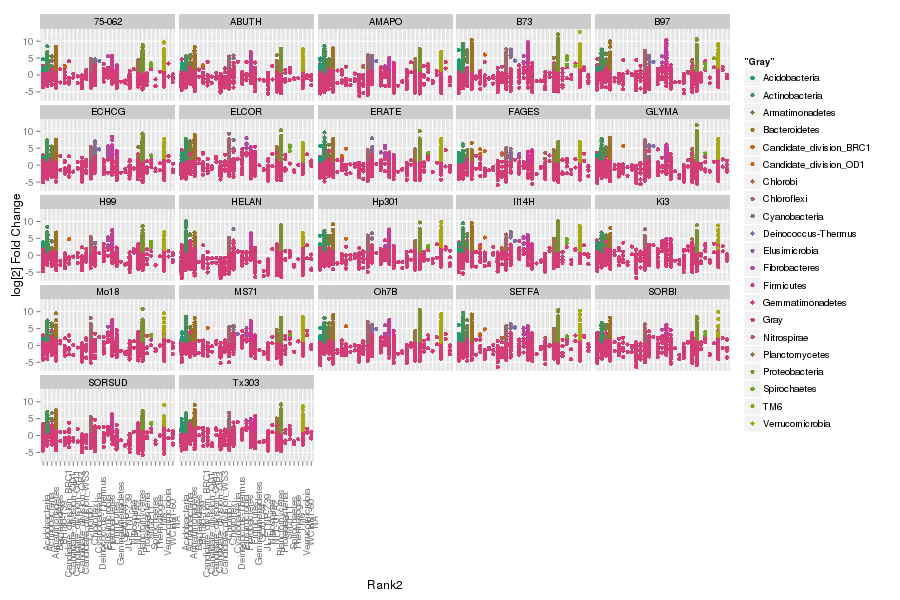

In [55]:
%%R -w 900 -h 600

colourCount = length(unique(df_all$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

df.sig = df_all[df_all$p.adj < .05,]
df.ns = df_all[df_all$p.adj >= .05,]

p = ggplot(df_all)+
    geom_point(data = df.ns, aes(Rank2, log2FoldChange, color = "Gray", position = "jitter")) +
    scale_shape_identity() +
    geom_point(data = df.sig, aes(Rank2, log2FoldChange, color = Rank2, position = "jitter")) +
    
               #geom_hline(y_intercept = .4) +
    
    facet_wrap(~Plant)+
    theme(axis.text.x = element_text(angle = 90)) +
    labs(y = "log[2] Fold Change") 

p = p + scale_color_manual(values = getPalette(colourCount))
#p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)
#p = p + theme_bw()




#p = p + geom_hline(y = l2fc.threshold)



#p = p + theme(axis.text.x = element_blank())

#p = p + labs(x = "Phylum", color = "Phylum")

#p = p + guides(col = guide_legend(ncol = 2))

#p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

#p = p + guides(colour = guide_legend(override.aes = list(size=4)))

p    
    

## Create same figure as above, but export to pdf with different plant on each page

In [56]:
%%R -w 900 -h 600

colourCount = length(unique(df_all$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

PlantList = levels(df_all$Plant)

pdf(file = '/home/bryan/RhizCG/figures/l2f_byplant.pdf')

for (plant in PlantList) {
    pl = df_all$Plant == plant
    df_plant = df_all[pl,]
    
df.sig = df_plant[df_plant$p.adj < .05,]
df.ns = df_plant[df_plant$p.adj >= .05,]

p = ggplot(df_plant)+
    geom_point(data = df.ns, aes(Rank2, log2FoldChange, color = "White", position = "jitter")) +
    scale_shape_identity() +
    geom_point(data = df.sig, aes(Rank2, log2FoldChange, color = Rank2, position = "jitter")) +
    
    ggtitle(paste(plant)) +
    
    theme(axis.text.x = element_text(angle = 90)) +
    labs(y = "log[2] Fold Change") 

p = p + scale_color_manual(values = getPalette(colourCount))
print(p)    
    }

dev.off()

png 
  2 


In [30]:
###Graph of taxa with significant log2fold change

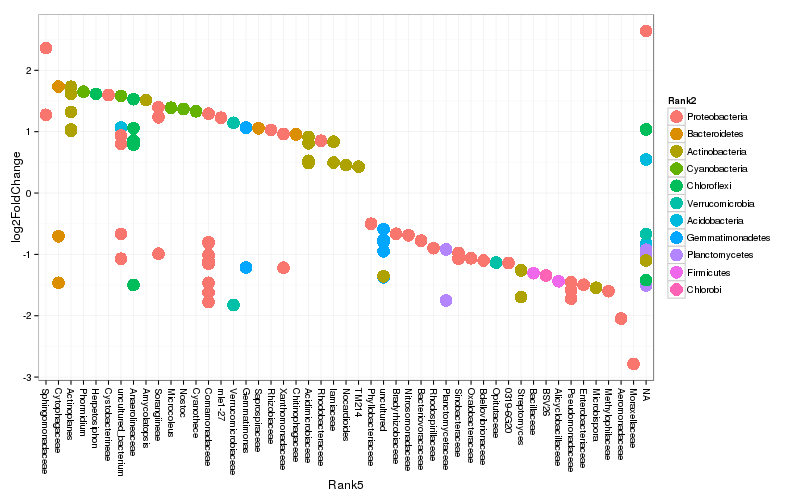

In [31]:
#%%R -w 800 -h 500
#theme_set(theme_bw())
#scale_fill_discrete <- function(palname = "Set1", ...) {
#    scale_fill_brewer(palette = palname, ...)
#}
# Phylum order
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
## Genus order
#x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
#x = sort(x, TRUE)
#sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
#ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2)) + geom_point(size=6) + 
#  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))

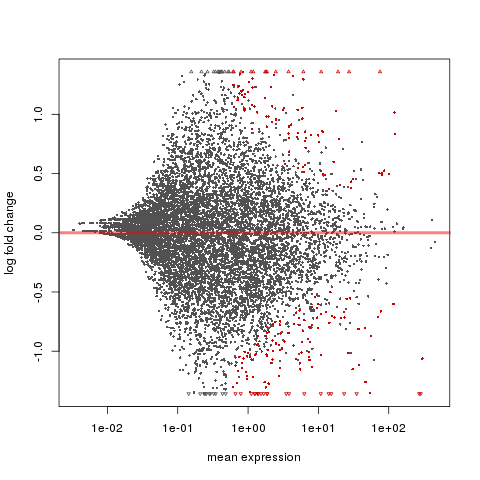

In [32]:
%%R
DESeq2::plotMA(res)